In [67]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip available: 22.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import os
os.getcwd()



'c:\\Users\\jmoli\\OneDrive\\Desktop\\deepkia_version\\ANN-Internal-Analysis\\data\\MNIST\\raw'

In [65]:
import sys
from pathlib import Path

# Sube directorios hasta encontrar la carpeta Analysis_Project
p = Path.cwd()
while p != p.parent and not (p / "Analysis_Project" / "activation_hooks.py").exists():
    p = p.parent

if not (p / "Analysis_Project" / "activation_hooks.py").exists():
    raise FileNotFoundError("Error Analysis_Project/activation_hooks.py ")

sys.path.insert(0, str(p))
print("Repo root detected:", p)

Repo root detected: c:\Users\jmoli\OneDrive\Desktop\deepkia_version\ANN-Internal-Analysis


In [66]:
from Analysis_Project.activation_hooks import *

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

print("PyTorch version:", torch.__version__)

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

PyTorch version: 2.7.1+cpu


In [19]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
test_set = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

len(train_set), len(test_set)

(60000, 10000)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [21]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0
    total = 0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch} | Train Loss: {running_loss/total:.4f} | "
          f"Train Acc: {100*correct/total:.2f}%")


def test():
    model.eval()
    test_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Loss: {test_loss/total:.4f} | "
          f"Test Acc: {100*correct/total:.2f}%")

In [22]:
num_epochs = 5  # MNIST learns quickly!

for epoch in range(1, num_epochs + 1):
    train_one_epoch(epoch)
    test()

Epoch 1 | Train Loss: 0.1643 | Train Acc: 95.06%
Test Loss: 0.0515 | Test Acc: 98.31%
Epoch 2 | Train Loss: 0.0466 | Train Acc: 98.59%
Test Loss: 0.0374 | Test Acc: 98.70%
Epoch 3 | Train Loss: 0.0317 | Train Acc: 99.00%
Test Loss: 0.0376 | Test Acc: 98.77%
Epoch 4 | Train Loss: 0.0251 | Train Acc: 99.18%
Test Loss: 0.0327 | Test Acc: 98.92%
Epoch 5 | Train Loss: 0.0175 | Train Acc: 99.46%
Test Loss: 0.0272 | Test Acc: 99.15%


In [23]:
import os

os.makedirs("models", exist_ok=True)  # create folder if not exists
model_path = os.path.join("models", "mnist_cnn.pth")
torch.save(model.state_dict(), model_path)
print("Model saved as", model_path)

Model saved as models\mnist_cnn.pth


In [24]:
import torch

activations = {}

def hook_fn(name):
    def hook(module, inp, out):
        activations[name] = out.detach()
    return hook

hooks = []
hooks.append(model.features[0].register_forward_hook(hook_fn("features.0_conv1")))
hooks.append(model.features[3].register_forward_hook(hook_fn("features.3_conv2")))
hooks.append(model.classifier[1].register_forward_hook(hook_fn("classifier.1_fc1")))
hooks.append(model.classifier[3].register_forward_hook(hook_fn("classifier.3_fc2_logits")))

# run one forward pass
images, labels = next(iter(test_loader))
_ = model(images)

print(activations.keys())
print({k: tuple(v.shape) for k, v in activations.items()})

dict_keys(['features.0_conv1', 'features.3_conv2', 'classifier.1_fc1', 'classifier.3_fc2_logits'])
{'features.0_conv1': (128, 32, 28, 28), 'features.3_conv2': (128, 64, 14, 14), 'classifier.1_fc1': (128, 128), 'classifier.3_fc2_logits': (128, 10)}


In [25]:
for h in hooks:
    h.remove()

In [26]:
import os
os.makedirs("models", exist_ok=True)

In [27]:
torch.save(model.state_dict(), "models/mnist_cnn.pth")
print("Model saved successfully!")

Model saved successfully!


In [28]:
import os
os.makedirs("../../models", exist_ok=True)

torch.save(model.state_dict(), "../../models/mnist_cnn.pth")

print("Model saved in project root models folder!")

Model saved in project root models folder!


In [29]:
os.makedirs("../../models", exist_ok=True)

In [30]:
torch.save(model.state_dict(), "../../models/mnist_cnn.pth")

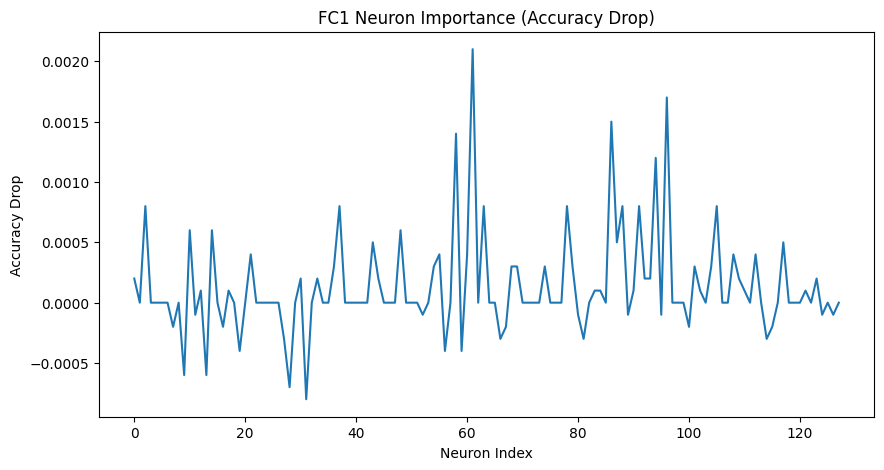

In [31]:
import json
import matplotlib.pyplot as plt

with open("../../../outputs/ablation_results/ablation_fc1_neurons.json") as f:
    fc_results = json.load(f)

drops = [r["acc_drop"] for r in fc_results]

plt.figure(figsize=(10,5))
plt.plot(drops)
plt.title("FC1 Neuron Importance (Accuracy Drop)")
plt.xlabel("Neuron Index")
plt.ylabel("Accuracy Drop")
plt.show()

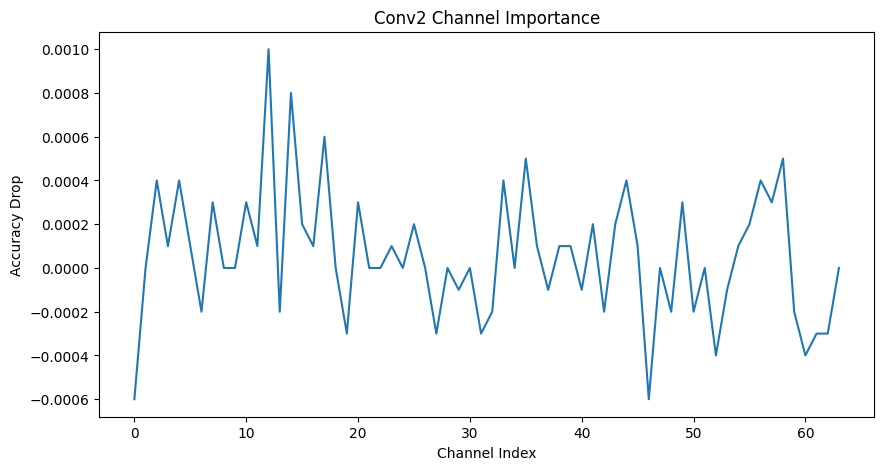

In [32]:
with open("../../../outputs/ablation_results/ablation_conv2_channels.json") as f:
    conv_results = json.load(f)

conv_drops = [r["acc_drop"] for r in conv_results]

plt.figure(figsize=(10,5))
plt.plot(conv_drops)
plt.title("Conv2 Channel Importance")
plt.xlabel("Channel Index")
plt.ylabel("Accuracy Drop")
plt.show()

In [33]:
import json
import matplotlib.pyplot as plt

# Load FC results
with open("../../../outputs/ablation_results/ablation_fc1_neurons.json") as f:
    fc_results = json.load(f)

# Load Conv results
with open("../../../outputs/ablation_results/ablation_conv2_channels.json") as f:
    conv_results = json.load(f)

# Extract accuracy drops
fc_drops = [r["acc_drop"] for r in fc_results]
conv_drops = [r["acc_drop"] for r in conv_results]

In [34]:
import numpy as np

fc_mean = np.mean(fc_drops)
conv_mean = np.mean(conv_drops)

fc_max = np.max(fc_drops)
conv_max = np.max(conv_drops)

print("FC1 Mean Drop:", fc_mean)
print("Conv2 Mean Drop:", conv_mean)

print("FC1 Max Drop:", fc_max)
print("Conv2 Max Drop:", conv_max)

FC1 Mean Drop: 0.00013125000000000723
Conv2 Mean Drop: 5.625000000001115e-05
FC1 Max Drop: 0.0020999999999999908
Conv2 Max Drop: 0.0010000000000000009


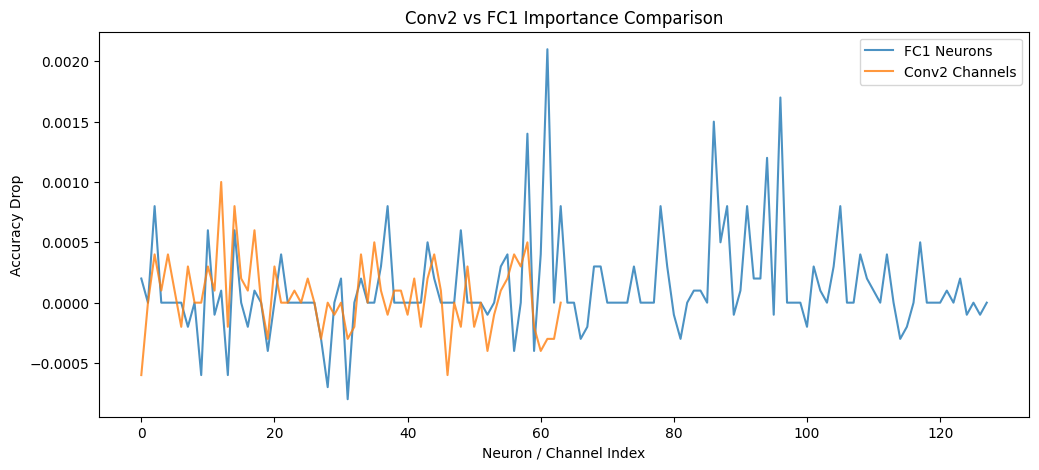

In [35]:
plt.figure(figsize=(12,5))

plt.plot(fc_drops, label="FC1 Neurons", alpha=0.8)
plt.plot(range(len(conv_drops)), conv_drops, label="Conv2 Channels", alpha=0.8)

plt.title("Conv2 vs FC1 Importance Comparison")
plt.xlabel("Neuron / Channel Index")
plt.ylabel("Accuracy Drop")
plt.legend()
plt.show()

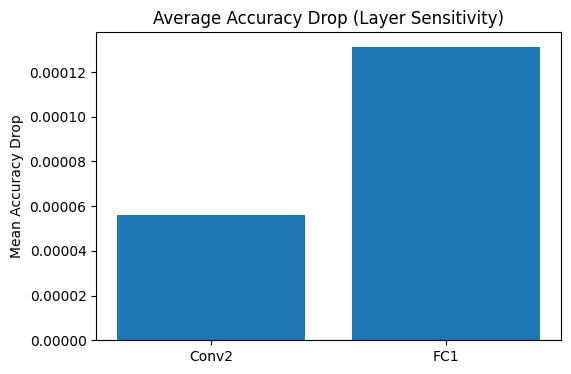

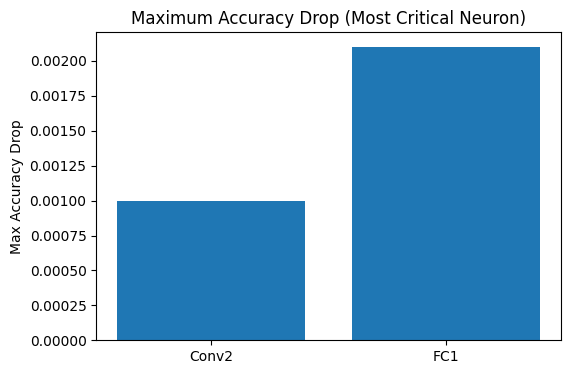

In [36]:
labels = ["Conv2", "FC1"]
means = [conv_mean, fc_mean]
max_vals = [conv_max, fc_max]

plt.figure(figsize=(6,4))
plt.bar(labels, means)
plt.title("Average Accuracy Drop (Layer Sensitivity)")
plt.ylabel("Mean Accuracy Drop")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(labels, max_vals)
plt.title("Maximum Accuracy Drop (Most Critical Neuron)")
plt.ylabel("Max Accuracy Drop")
plt.show()

In [37]:
top5 = sorted(fc_results, key=lambda x: x["acc_drop"], reverse=True)[:5]
top5

[{'type': 'fc_neuron',
  'layer': 'classifier[1]',
  'neuron': 61,
  'baseline_acc': 0.9898,
  'ablated_acc': 0.9877,
  'acc_drop': 0.0020999999999999908},
 {'type': 'fc_neuron',
  'layer': 'classifier[1]',
  'neuron': 96,
  'baseline_acc': 0.9898,
  'ablated_acc': 0.9881,
  'acc_drop': 0.0017000000000000348},
 {'type': 'fc_neuron',
  'layer': 'classifier[1]',
  'neuron': 86,
  'baseline_acc': 0.9898,
  'ablated_acc': 0.9883,
  'acc_drop': 0.0015000000000000568},
 {'type': 'fc_neuron',
  'layer': 'classifier[1]',
  'neuron': 58,
  'baseline_acc': 0.9898,
  'ablated_acc': 0.9884,
  'acc_drop': 0.0014000000000000679},
 {'type': 'fc_neuron',
  'layer': 'classifier[1]',
  'neuron': 94,
  'baseline_acc': 0.9898,
  'ablated_acc': 0.9886,
  'acc_drop': 0.0011999999999999789}]

In [38]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load FC ablation results
with open("../../../outputs/ablation_results/ablation_fc1_neurons.json") as f:
    fc_results = json.load(f)

# Load Conv2 ablation results
with open("../../../outputs/ablation_results/ablation_conv2_channels.json") as f:
    conv_results = json.load(f)

fc_df = pd.DataFrame(fc_results)
conv_df = pd.DataFrame(conv_results)

fc_df.head(), conv_df.head()

(        type          layer  neuron  baseline_acc  ablated_acc  acc_drop
 0  fc_neuron  classifier[1]       0        0.9898       0.9896    0.0002
 1  fc_neuron  classifier[1]       1        0.9898       0.9898    0.0000
 2  fc_neuron  classifier[1]       2        0.9898       0.9890    0.0008
 3  fc_neuron  classifier[1]       3        0.9898       0.9898    0.0000
 4  fc_neuron  classifier[1]       4        0.9898       0.9898    0.0000,
            type        layer  channel  baseline_acc  ablated_acc  acc_drop
 0  conv_channel  features[3]        0        0.9898       0.9904   -0.0006
 1  conv_channel  features[3]        1        0.9898       0.9898    0.0000
 2  conv_channel  features[3]        2        0.9898       0.9894    0.0004
 3  conv_channel  features[3]        3        0.9898       0.9897    0.0001
 4  conv_channel  features[3]        4        0.9898       0.9894    0.0004)

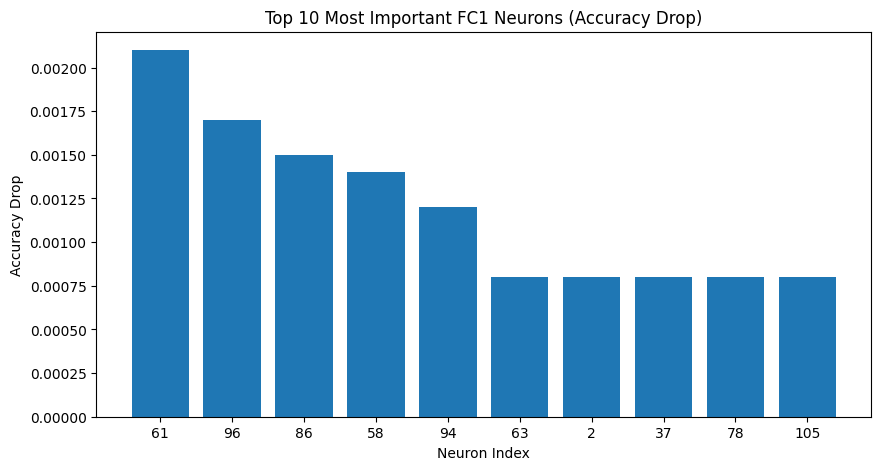

In [39]:
topk = 10
top_fc = fc_df.sort_values("acc_drop", ascending=False).head(topk)

plt.figure(figsize=(10,5))
plt.bar(top_fc["neuron"].astype(str), top_fc["acc_drop"])
plt.title(f"Top {topk} Most Important FC1 Neurons (Accuracy Drop)")
plt.xlabel("Neuron Index")
plt.ylabel("Accuracy Drop")
plt.show()

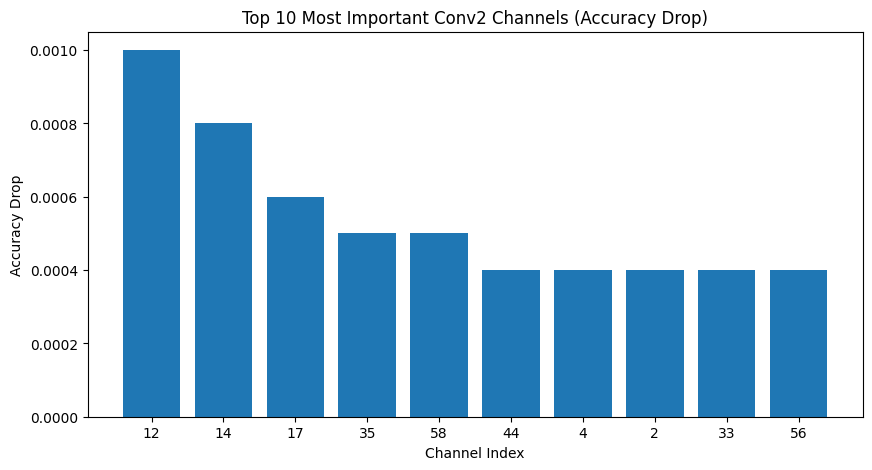

In [40]:
topk = 10
top_conv = conv_df.sort_values("acc_drop", ascending=False).head(topk)

plt.figure(figsize=(10,5))
plt.bar(top_conv["channel"].astype(str), top_conv["acc_drop"])
plt.title(f"Top {topk} Most Important Conv2 Channels (Accuracy Drop)")
plt.xlabel("Channel Index")
plt.ylabel("Accuracy Drop")
plt.show()

In [41]:
top_neuron = int(fc_df.sort_values("acc_drop", ascending=False).iloc[0]["neuron"])
top_drop = float(fc_df.sort_values("acc_drop", ascending=False).iloc[0]["acc_drop"])
print("Top FC1 neuron:", top_neuron, "drop:", top_drop)

Top FC1 neuron: 61 drop: 0.0020999999999999908


In [42]:
import torch
import torch.nn as nn

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_CNN().to(device)
model.load_state_dict(torch.load("../../../models/mnist_cnn.pth", map_location=device))
model.eval()

print("Model loaded successfully")

Model loaded successfully


In [44]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_set = torchvision.datasets.MNIST(
    root="../../../data", train=False, download=True, transform=transform
)

test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [45]:
import torch
import torch.nn as nn

# Hook FC1 output (the layer is classifier[1] = Linear)
fc1_acts = []

def fc1_hook(module, inp, out):
    # out shape: [batch, 128]
    fc1_acts.append(out.detach().cpu())

handle = model.classifier[1].register_forward_hook(fc1_hook)

model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _ = model(images)

handle.remove()

acts = fc1_acts[0]               # [batch, 128]
neuron_values = acts[:, top_neuron]  # [batch]
top_idx = torch.topk(neuron_values, k=8).indices.tolist()

print("Top activating indices:", top_idx)

Top activating indices: [43, 103, 49, 33, 56, 117, 109, 88]


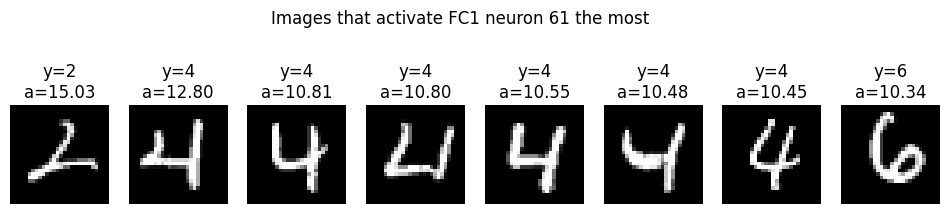

In [46]:
imgs = images.detach().cpu()

plt.figure(figsize=(12,3))
for i, idx in enumerate(top_idx):
    plt.subplot(1, len(top_idx), i+1)
    plt.imshow(imgs[idx][0], cmap="gray")
    plt.title(f"y={labels[idx].item()}\na={neuron_values[idx].item():.2f}")
    plt.axis("off")
plt.suptitle(f"Images that activate FC1 neuron {top_neuron} the most")
plt.show()

In [47]:
# Basic stats
fc_mean = fc_df["acc_drop"].mean()
fc_max = fc_df["acc_drop"].max()
conv_mean = conv_df["acc_drop"].mean()
conv_max = conv_df["acc_drop"].max()

top_fc_row = fc_df.sort_values("acc_drop", ascending=False).iloc[0]
top_conv_row = conv_df.sort_values("acc_drop", ascending=False).iloc[0]

interpretation = f"""
Interpretation of Ablation Results
---------------------------------
We performed single-unit ablations to estimate importance by measuring the drop in test accuracy
after disabling one unit at a time.

FC1 layer: average accuracy drop = {fc_mean:.6f}, maximum drop = {fc_max:.6f}
Top FC1 neuron: index {int(top_fc_row['neuron'])} with drop {float(top_fc_row['acc_drop']):.6f}

Conv2 layer: average accuracy drop = {conv_mean:.6f}, maximum drop = {conv_max:.6f}
Top Conv2 channel: index {int(top_conv_row['channel'])} with drop {float(top_conv_row['acc_drop']):.6f}

Overall, the layer with the higher average drop is more sensitive to single-unit removal, indicating
its units tend to contribute more consistently to accuracy. The maximum drop highlights the most
critical single unit discovered in each layer.
"""
print(interpretation)


Interpretation of Ablation Results
---------------------------------
We performed single-unit ablations to estimate importance by measuring the drop in test accuracy
after disabling one unit at a time.

FC1 layer: average accuracy drop = 0.000131, maximum drop = 0.002100
Top FC1 neuron: index 61 with drop 0.002100

Conv2 layer: average accuracy drop = 0.000056, maximum drop = 0.001000
Top Conv2 channel: index 12 with drop 0.001000

Overall, the layer with the higher average drop is more sensitive to single-unit removal, indicating
its units tend to contribute more consistently to accuracy. The maximum drop highlights the most
critical single unit discovered in each layer.



In [48]:
top_fc = fc_df.sort_values("acc_drop", ascending=False).head(10)[["layer","neuron","acc_drop","ablated_acc","baseline_acc"]]
top_conv = conv_df.sort_values("acc_drop", ascending=False).head(10)[["layer","channel","acc_drop","ablated_acc","baseline_acc"]]

summary_stats = pd.DataFrame([
    {"group":"FC1", "mean_drop": fc_df["acc_drop"].mean(), "max_drop": fc_df["acc_drop"].max(), "min_drop": fc_df["acc_drop"].min()},
    {"group":"Conv2", "mean_drop": conv_df["acc_drop"].mean(), "max_drop": conv_df["acc_drop"].max(), "min_drop": conv_df["acc_drop"].min()},
])

display(summary_stats)
display(top_fc)
display(top_conv)

,group,mean_drop,max_drop,min_drop
0,FC1,0.000131,0.0021,-0.0008
1,Conv2,0.000056,0.0010,-0.0006


,layer,neuron,acc_drop,ablated_acc,baseline_acc
61,classifier[1],61,0.0021,0.9877,0.9898
96,classifier[1],96,0.0017,0.9881,0.9898
86,classifier[1],86,0.0015,0.9883,0.9898
58,classifier[1],58,0.0014,0.9884,0.9898
94,classifier[1],94,0.0012,0.9886,0.9898
63,classifier[1],63,0.0008,0.9890,0.9898
2,classifier[1],2,0.0008,0.9890,0.9898
37,classifier[1],37,0.0008,0.9890,0.9898
78,classifier[1],78,0.0008,0.9890,0.9898
105,classifier[1],105,0.0008,0.9890,0.9898


,layer,channel,acc_drop,ablated_acc,baseline_acc
12,features[3],12,0.0010,0.9888,0.9898
14,features[3],14,0.0008,0.9890,0.9898
17,features[3],17,0.0006,0.9892,0.9898
35,features[3],35,0.0005,0.9893,0.9898
58,features[3],58,0.0005,0.9893,0.9898
44,features[3],44,0.0004,0.9894,0.9898
4,features[3],4,0.0004,0.9894,0.9898
2,features[3],2,0.0004,0.9894,0.9898
33,features[3],33,0.0004,0.9894,0.9898
56,features[3],56,0.0004,0.9894,0.9898


In [49]:
summary_stats.to_csv("ablation_summary_stats.csv", index=False)
top_fc.to_csv("top10_fc1_neurons.csv", index=False)
top_conv.to_csv("top10_conv2_channels.csv", index=False)
print("Saved CSV files in the notebook folder.")

Saved CSV files in the notebook folder.


In [50]:
model = MNIST_CNN()
optimizer = ...


In [51]:
import copy
w_before = copy.deepcopy(model.state_dict())
print("Saved initial weights snapshot.")

Saved initial weights snapshot.


In [52]:
w_after = model.state_dict()

# FC1 weight change (classifier[1])
delta_fc1 = (w_after["classifier.1.weight"] - w_before["classifier.1.weight"]).detach().cpu()

print("FC1 delta mean:", delta_fc1.mean().item())
print("FC1 delta std:", delta_fc1.std(unbiased=False).item())
print("FC1 delta max abs:", delta_fc1.abs().max().item())

import os, torch
os.makedirs("../../../outputs/weight_deltas", exist_ok=True)
torch.save(delta_fc1, "../../../outputs/weight_deltas/fc1_weight_delta.pt")
print("Saved: ../../../outputs/weight_deltas/fc1_weight_delta.pt")

FC1 delta mean: 0.0
FC1 delta std: 0.0
FC1 delta max abs: 0.0
Saved: ../../../outputs/weight_deltas/fc1_weight_delta.pt


In [53]:
import copy
w_before = copy.deepcopy(model.state_dict())

In [54]:
import torch.nn as nn
import torch.optim as optim

model = MNIST_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [55]:
import copy
w_before = copy.deepcopy(model.state_dict())
print("Saved initial weights snapshot BEFORE training.")

Saved initial weights snapshot BEFORE training.


In [56]:
import copy
w_before = copy.deepcopy(model.state_dict())
print("Saved w_before BEFORE training")

Saved w_before BEFORE training


In [57]:
model.train()
for epoch in range(1):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
print("Finished 1 epoch")

Finished 1 epoch


In [58]:
w_after = model.state_dict()

delta_fc1 = (
    w_after["classifier.1.weight"]
    - w_before["classifier.1.weight"]
).detach().cpu()

print("FC1 delta mean:", float(delta_fc1.mean()))
print("FC1 delta std:", float(delta_fc1.std(unbiased=False)))
print("FC1 delta max abs:", float(delta_fc1.abs().max()))

FC1 delta mean: -0.0003064681077376008
FC1 delta std: 0.013728872872889042
FC1 delta max abs: 0.13478437066078186


In [59]:
w_after = model.state_dict()

delta_fc1 = (w_after["classifier.1.weight"] - w_before["classifier.1.weight"]).detach().cpu()

print("FC1 delta mean:", delta_fc1.mean().item())
print("FC1 delta std:", delta_fc1.std(unbiased=False).item())
print("FC1 delta max abs:", delta_fc1.abs().max().item())

FC1 delta mean: -0.0003064681077376008
FC1 delta std: 0.013728872872889042
FC1 delta max abs: 0.13478437066078186


In [60]:
import os, torch
os.makedirs("../../../outputs/weight_deltas", exist_ok=True)
torch.save(delta_fc1, "../../../outputs/weight_deltas/fc1_weight_delta.pt")
print("Saved delta file to outputs/weight_deltas/")

Saved delta file to outputs/weight_deltas/


In [61]:
import json

path = "../../../outputs/weight_analysis/fc1_weight_contribution_analysis.json"
with open(path, "r", encoding="utf-8") as f:
    report = json.load(f)

# 1) Size of weights |w| + stats
print("=== WEIGHT STATS (FC1) ===")
print("W_shape:", report["weights"]["W_shape"])
print("W_stats:", report["weights"]["W_stats"])
print("sign_counts:", report["weights"]["sign_counts"])

# 2) w*o for all patterns
print("\n=== w * o (ALL PATTERNS) ===")
print("patterns:", report["w_times_o_all_patterns"]["patterns"])
print("contrib_mean_stats:", report["w_times_o_all_patterns"]["contrib_mean_stats"])
print("contrib_abs_mean_stats:", report["w_times_o_all_patterns"]["contrib_abs_mean_stats"])

# 3) contribution ratio stats
print("\n=== CONTRIBUTION RATIO ===")
print("ratio_stats:", report["contribution_ratio"]["ratio_stats"])
print("top_inputs_first5_neurons:", report["contribution_ratio"]["top_inputs_first5_neurons"])

# 4) class-specific w*o
print("\n=== CLASS-SPECIFIC (show 2 classes) ===")
for c in ["0", "1"]:
    if c in report["class_specific"]:
        print(f"Class {c} count:", report["class_specific"][c]["count"])
        print("top20_inputs:", report["class_specific"][c]["top20_inputs"])
        print("top20_scores:", report["class_specific"][c]["top20_scores"])

# 5) weight ablation (importance of weights)
print("\n=== WEIGHT ABLATION RESULTS ===")
for r in report["weight_ablation"]:
    print(r)

=== WEIGHT STATS (FC1) ===
W_shape: [128, 3136]
W_stats: {'mean': -0.001020626281388104, 'std': 0.027350090444087982, 'min': -0.2617160677909851, 'max': 0.284446120262146, 'abs_mean': 0.019203025847673416, 'abs_max': 0.284446120262146}
sign_counts: {'positive': 187172, 'negative': 214236, 'zero': 0}

=== w * o (ALL PATTERNS) ===
patterns: 10000
contrib_mean_stats: {'mean': -0.0003264191036578268, 'std': 0.014786235056817532, 'min': -0.30691656470298767, 'max': 0.32082030177116394, 'abs_mean': 0.006218719761818647, 'abs_max': 0.32082030177116394}
contrib_abs_mean_stats: {'mean': 0.006218719761818647, 'std': 0.013418897986412048, 'min': 0.0, 'max': 0.32082030177116394, 'abs_mean': 0.006218719761818647, 'abs_max': 0.32082030177116394}

=== CONTRIBUTION RATIO ===
ratio_stats: {'mean': 0.0003188775444868952, 'std': 0.0006034278776496649, 'min': 0.0, 'max': 0.012291062623262405, 'abs_mean': 0.0003188775444868952, 'abs_max': 0.012291062623262405}
top_inputs_first5_neurons: [{'neuron': 0, 'top